In [1]:
#%pip install pybamm -q    # install PyBaMM if it is not installed
#import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
start = timeit.default_timer()
#os.chdir(pybamm.__path__[0]+'/..')
# pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.DFN(
    options={
        "particle": "Fickian diffusion", 
        "SEI":"none", 
        "SEI film resistance":"none", 
        "SEI porosity change":"false",
        "particle cracking":"none",
        "loss of active material":"none",
        "lithium plating": "none",
    }
)

In [3]:
chemistry = pybamm.parameter_sets.Chen2020
param = pybamm.ParameterValues(chemistry=chemistry)
param.update({"Upper voltage cut-off [V]": 4.21})
# param.update({"Inner SEI reaction proportion":0})
# param.update({"Initial inner SEI thickness [m]":0})
# param.update({"Initial outer SEI thickness [m]": 5e-9})
# param.update({"Ratio of inner and outer SEI exchange current densities": 0 })
# param.update({"Negative electrode cracking rate":3.9e-20})
# param.update({"Outer SEI solvent diffusivity [m2.s-1]": 2.5e-22})
# param.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-9})
# param.update({"SEI-plating coupling constant [s-1]": 1E-6})

In [4]:
total_cycles=10
exp = pybamm.Experiment(["Hold at 4.2V until C/100", "Rest for 4 hours"] + [("Discharge at 1C until 2.5V",
    "Charge at 0.3C until 4.2V", "Hold at 4.2V until C/100",),
]*total_cycles,use_simulation_setup_type='old')

In [5]:
sim1 = pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
)
solution1 = sim1.solve()

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s') 
#solution1.save('/mnt/e/pybamm_data/FullyCoupled_reference.pkl')

running time: 358.3641910000006s


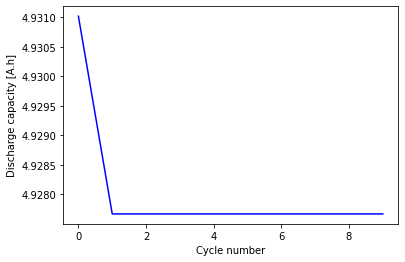

In [6]:
cycle_number = []
Qdis_delta = []
for i in range(total_cycles):
    Qdis = solution1.cycles[i+2].steps[0]["Discharge capacity [A.h]"].entries
    Qdis_delta.append(Qdis[-1] - Qdis[0])
    cycle_number.append(i)
#plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
ax.plot(cycle_number, Qdis_delta, color="blue")
plt.xlabel("Cycle number")
plt.ylabel("Discharge capacity [A.h]")
#fig.savefig('/mnt/e/pybamm_data/FullyCoupled_reference_cycles.pdf')
plt.show()
M_cycles = np.array([cycle_number,Qdis_delta])
#np.savetxt("/mnt/e/pybamm_data/FullyCoupled_reference_cycles.txt",M_cycles,delimiter=",")